In [3]:
%matplotlib inline


# Symbolic Aggregate approXimation

Binning continuous data into intervals can be seen as an approximation that
reduces noise and captures the trend of a time series. The Symbolic Aggregate
approXimation (SAX) algorithm bins continuous time series into intervals,
transforming independently each time series (a sequence of floats) into a
sequence of symbols, usually letters. This example illustrates the
transformation.
It is implemented as
:class:`pyts.approximation.SymbolicAggregateApproximation`.


### Example:
* 12-point Time Series

### Parameters:
* 4 segments (w=4),
* 3 alphabet size (a=3)


In [8]:
# Import libraries
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

In [28]:
# 1. Define the raw data
ts = np.array([18, 19, 21, 25, 24, 22, 15, 12, 11, 14, 17, 20])
n = len(ts)
w = 4  # number of PAA segments
a = 3  # alphabet size
pts_per_seg = n // w

In [10]:
# 2. Z-Normalization
ts_norm = (ts - np.mean(ts)) / np.std(ts)

In [12]:
# 3. PAA (Piecewise Aggregate Approximation)
# We reshape the array to (4 segments, 3 points each) and take the mean of each row
paa = ts_norm.reshape(w, -1).mean(axis=1)
paa

array([ 0.26903185,  1.26829303, -1.26829303, -0.26903185])

In [14]:
# 4. Generate Breakpoints for Alphabet Size 3
# Area thresholds for a=3: [1/3, 2/3]
breakpoints = [norm.ppf(i/a) for i in range(1, a)]
breakpoints

[np.float64(-0.43072729929545756), np.float64(0.43072729929545744)]

In [16]:
# 5. Symbolic Discretization (SAX)
def map_to_alphabet(val, bps):
    alphabet = "abcdefghijklmnopqrstuvwxyz"
    for i, b in enumerate(bps):
        if val <= b:
            return alphabet[i]
    return alphabet[len(bps)]

sax_string = "".join([map_to_alphabet(v, breakpoints) for v in paa])
sax_string

'bcab'

In [21]:
print(f"Original Data: {ts}")
print(f"PAA Coefficients: {paa.round(3)}")
print(f"SAX String: {sax_string}")

Original Data: [18 19 21 25 24 22 15 12 11 14 17 20]
PAA Coefficients: [ 0.269  1.268 -1.268 -0.269]
SAX String: bcab


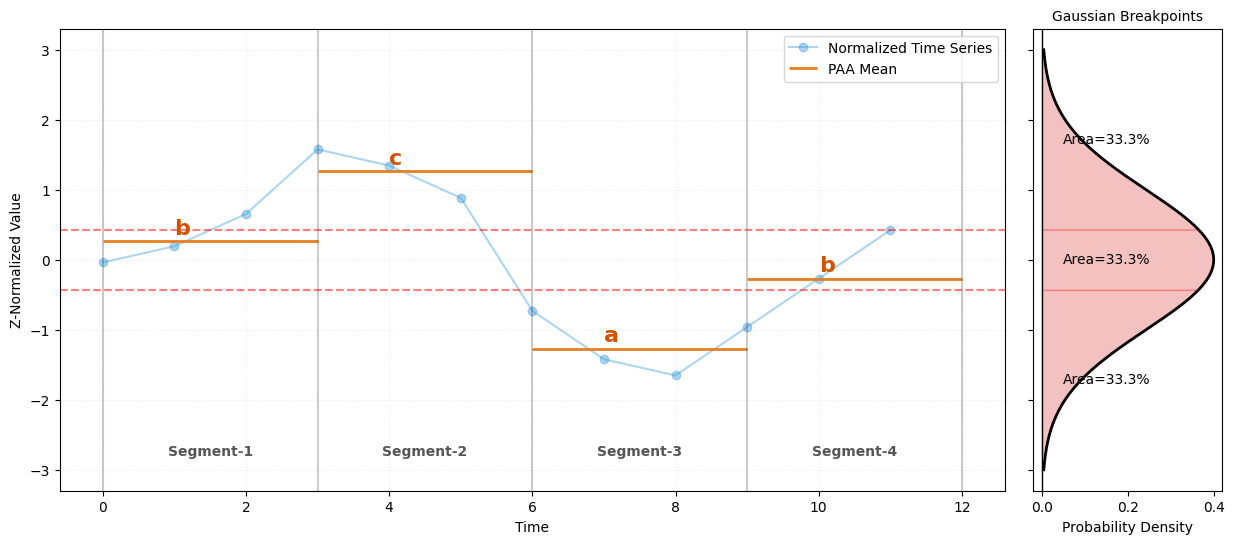

In [47]:
# 3. Visualization with Normal Distribution Curve
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6), sharey=True, gridspec_kw={'width_ratios': [5, 1]})
fig.subplots_adjust(wspace=0.05)

# --- Left Plot: Time Series & PAA ---
ax1.plot(range(n), ts_norm, marker='o', label='Normalized Time Series', color='#3498db', alpha=0.4)
#paa_extended = np.repeat(paa, n//w)
#ax1.step(range(n), paa_extended, where='post', label='PAA (Means)', color='#e67e22', lw=3)

# Add Vertical Segment Lines and Labels
for i in range(w + 1):
    x_pos = i * pts_per_seg
    ax1.axvline(x=x_pos, color='black', linestyle='-', alpha=0.2)
    if i < w:
        # Label the segment at the top
        ax1.text(x_pos + pts_per_seg/2, -2.8, f"Segment-{i+1}",ha='center', weight='bold', color='#555')
        # Plot the PAA Mean as a horizontal bar within the segment
        ax1.hlines(paa[i], x_pos, x_pos + pts_per_seg, colors='#e67e22', lw=2, label='PAA Mean' if i==0 else "")

# Draw horizontal breakpoints
for bp in breakpoints:
    ax1.axhline(y=bp, color='red', linestyle='--', alpha=0.5)

# Annotate the SAX symbols
for i, symbol in enumerate(sax_string):
    ax1.text(i*3 + 1, paa[i] + 0.1, symbol.lower(), fontsize=16, fontweight='bold', color='#d35400')

#ax1.set_title(f"SAX Representation: '{sax_string}' (Segments=4, Alphabet=3)" , fontsize=14)
ax1.set_xlabel("Time")
ax1.set_ylabel("Z-Normalized Value")
ax1.legend(loc='upper right')
#ax1.grid(True, alpha=0.05)
ax1.grid(True, which='both', linestyle=':', alpha=0.25)

# --- Right Plot: Normal Distribution Curve ---
y_range = np.linspace(-3, 3, 500)
x_pdf = norm.pdf(y_range)

ax2.plot(x_pdf, y_range, color='black', lw=2, label='Normal Dist')
ax2.fill_betweenx(y_range, 0, x_pdf, color='gray', alpha=0.1)

# Color the regions on the curve to match the breakpoints
colors = ['#f9ebea', '#ebf5fb', '#f4fbf4'] # subtle colors for regions a, b, c
bounds = [-3] + breakpoints + [3]
for i in range(len(bounds)-1):
    fill_y = np.linspace(bounds[i], bounds[i+1], 100)
    ax2.fill_betweenx(fill_y, 0, norm.pdf(fill_y), color='red', alpha=0.2)
    # Add label for the region
    ax2.text(0.05, (bounds[i]+bounds[i+1])/2, f"Area={100/a:.1f}%", verticalalignment='center')

ax2.set_title("Gaussian Breakpoints", fontsize=10)
ax2.set_xlabel("Probability Density")
ax2.axvline(0, color='black', lw=1)

plt.show()
#plt.savefig('sax_example.png', dpi=300)